In [1]:
import torch
import numpy as np
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
%matplotlib inline

from main import train_and_eval, train_loader, test_loader

### Visualize training and testing data

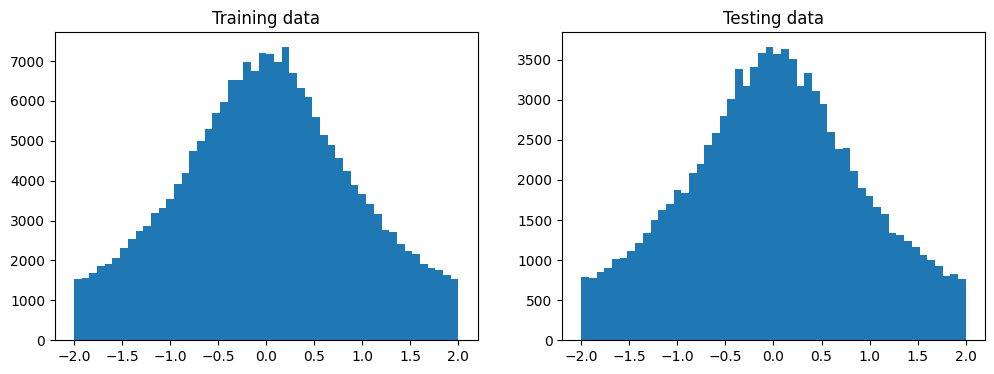

In [2]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Testing data')

### Train the composable flow model

In [ ]:
target_distribution = Uniform(0.0, 1.0)
flow, train_losses, test_losses = train_and_eval(150, 1e-2, train_loader, test_loader, target_distribution)

### View the losses

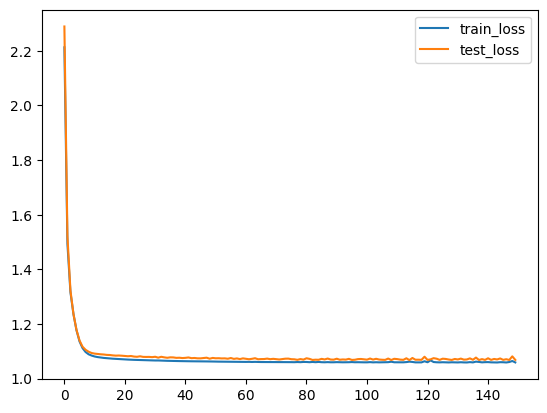

In [ ]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
plt.legend()

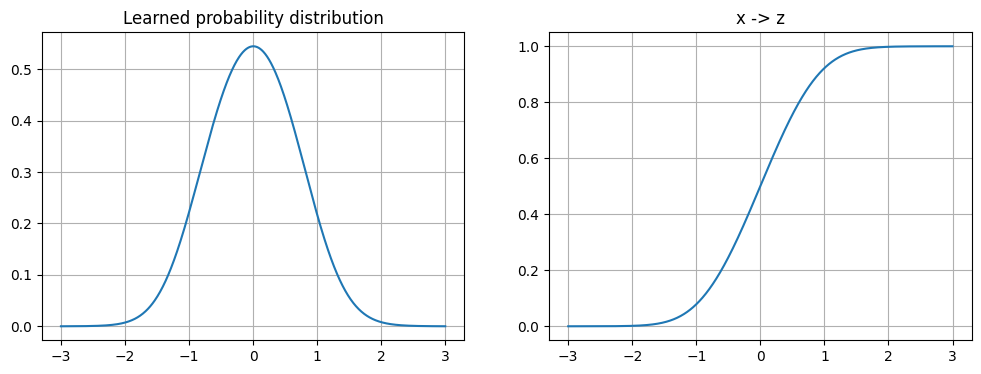

In [ ]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned probability distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

### Empirical distribution of z

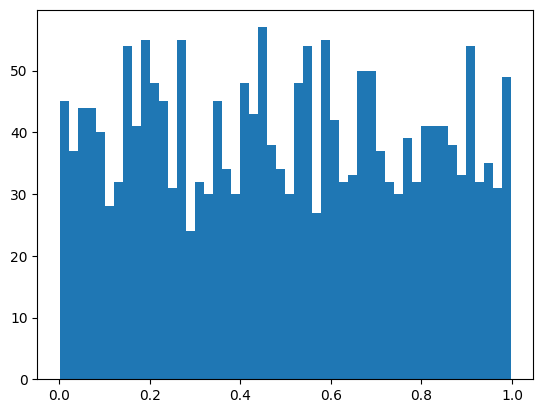

In [ ]:
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(train_loader.dataset.array))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp().cpu().numpy()
    
_ = plt.hist(z, bins=50)

In [ ]:
# %% [markdown]
# Hyrbid Importance Sampling with Markov Chains For Monte Crlo Integration

# %%

#==============================Dependencies================================

#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

# %%
# Gaussian proposal
def gaussian_proposal(x, step_size):
    return x + step_size * np.random.normal()

# Cauchy distribution: p(x) = 1 / (π * (1 + x^2))
def cauchy_distribution(x, step_size):
    return (step_size) * 1 / (pi * (1 + x**2))

# Uniform sampling proposal
def uniform_proposal(x, step_size):
    return x + step_size * rng.uniform(-1, 1)

# %%
#=======================Metropolis-Hastings Algorithm (Python)========================
def metropolis_python(f, N, x0, step_size, burnin, thinning, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    total_steps = N * thinning + burnin
    samples = []
    x = x0
    count = 0

    for i in range(total_steps):
        x_cand = x + rng.uniform(-step_size, step_size)
        alpha = min(1.0, abs(f(x_cand) / f(x)))
        if rng.uniform() < alpha:
            x = x_cand
            count += 1
        if i >= burnin and (i - burnin) % thinning == 0:
            samples.append(x)
    acceptance_rate = count / total_steps
    return np.array(samples)

# %%
#=======================Kernel Density Estimation (KDE) Functions========================

# Fixed-bandwidth KDE
def pilot_kde(samples, bandwidth): #fixed KDE mthod
    """Fixed-bandwidth KDE using Gaussian kernel."""
    def kde_eval(x_eval):
        x_eval = np.atleast_1d(x_eval)
        n = len(samples)
        coeff = 1 / (n * bandwidth * np.sqrt(2 * np.pi))
        diffs = (x_eval[:, None] - samples[None, :]) / bandwidth
        return coeff * np.sum(np.exp(-0.5 * diffs**2), axis=1)
    return kde_eval

def silverman_bandwidth(samples):
    n = len(samples)
    std = np.std(samples, ddof=1)
    return 1.06 * std * n ** (-1/5)

# Adaptive-bandwidth KDE
def adaptive_kde(samples, h_fixed, alpha=0.5): # Adative KDE method
    """
    Adaptive KDE using Abramson's square-root law.
    samples : 1D array of data points
    h_fixed : base bandwidth for pilot KDE
    alpha   : sensitivity parameter (default 0.5)
    """
    n = len(samples)

    # Step 1: pilot density estimate
    pilot = pilot_kde(samples, h_fixed)
    f_i = pilot(samples)

    # Step 2: compute geometric mean of pilot estimates
    g = np.exp(np.mean(np.log(f_i)))

    # Step 3: compute local bandwidth factors
    lambda_i = (f_i / g)**(-alpha)
    h_i = h_fixed * lambda_i

    # Step 4: adaptive KDE function
    def kde_adaptive(x_eval):
        x_eval = np.atleast_1d(x_eval)
        coeffs = 1 / (np.sqrt(2 * np.pi) * h_i)
        diffs = (x_eval[:, None] - samples[None, :]) / h_i
        result = np.sum(coeffs * np.exp(-0.5 * diffs**2), axis=1) / n
        return result

    return kde_adaptive

# %%
def hybrid_importance_sampling(f, m_chain, kde_pdf):
    """
    Estimate the integral of f using importance sampling from KDE-estimated proposal.

    Returns:
        estimate: Monte Carlo estimate of the integral
        stderr: Standard error of the estimate (not just std of weights)
    """
    weights = f(m_chain) / kde_pdf(m_chain)
    estimate = np.mean(weights)
    
    
    n = len(weights)
    variance = np.var(weights, ddof=1) / n    # variance of the estimator
    stderr = np.sqrt(variance) / np.sqrt(n)               # standard error of the estimator

    return estimate, variance, stderr


# %%
def f(x):
    return np.exp(-x**2)

# %%
#========================Example Usage of Hybrid Importance Sampling========================
N=10000
m_chain = metropolis_python(f, N, rng.uniform(-10, 10), 4, 2000, 10)
h_fixed = silverman_bandwidth(m_chain)
kde = adaptive_kde(m_chain, h_fixed, alpha=0.05)

print("Hybrid Importance Sampling Estimate:"),
hybrid_importance_sampling(f, m_chain, kde)